# Survival Analysis of Endometrial Cancer: Tumor Pathological Stage

Through modern statistical methods, we can determine survival risk based on a variety of factors.  In this tutorial, we will walk through a small example of something you could do with our data to understand what factors relate with survival in various different types of cancer.  In this use case, we will be looking at Endometrial Cancer

## Step 1: Import Data and Dependencies

In [1]:
import pandas as pd
import cptac
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
%matplotlib inline

In [26]:
en = cptac.Endometrial()
clinical = en.get_clinical()
proteomics = en.get_proteomics()
follow_up = en.get_followup()

## Step 2: Data Preparation
We will be focusing on the discovery cohort of tumors, for which we have follow-up data. We will first merge the clinical and follow-up tables together for analysis. Then we will choose a few attributes to focus on, and narrow our dataframe to those attributes. While you could study a wide variety of factors related to survival, such as country of origin or number of full pregnancies, we will be focusing on tumor stage and grade.

In [28]:
#Determine columns to focus on, and create a subset to work with
#NOTE. NEED TO PUT BACK IN THE CODE TO CREATE THE TIMEFRAME COLUMN
patient_data = pd.merge(clinical, follow_up, on = 'Patient_ID')

columns_to_focus_on = ['Vital Status', 
                       'Histologic_Grade_FIGO', 
                       'Path Diag to Last Contact(Day)', 
                       'Path Diag to Death(days)',
                       'tumor_Stage-Pathological',
                       'Path Diag to new Tumor (days)']

focus_group = patient_data[columns_to_focus_on].copy().drop_duplicates()

## Step 2b: Prepare data for Kaplan Meier Plotting
We will start by finding all patients that have died during the follow-up period and update the column to contain boolean values, where True denotes that the event occurred ('Deceased'), and False denotes that it did not ('Living').

In [30]:
#There is one erroneous negative value in this column, so we will remove it from our subset
focus_group = focus_group[focus_group['Path Diag to new Tumor (days)'] != -1562.0]

#Make the Vital Status column boolean
focus_group['Vital Status'] = focus_group['Vital Status'].replace('Living', False)
focus_group['Vital Status'] = focus_group['Vital Status'].replace('Deceased', True)

Next, we will subset the data to just the attributes we are testing for survival (numeric values), an event-of-interest column ('Vital Status'; boolean) and a column with a numeric time frame ('Path Diag to Last Contact(Day)'; numeric). This format is necessary for creating Kaplan Meier plots and running survival analysis, so be sure that your data is in this format.

In [ ]:
focus_group = focus_group[["Histologic_Grade_FIGO", "tumor_Stage-Pathological", 
                           "Vital Status", "Path Diag to Last Contact(Day)"]].dropna().copy()

figo_map = {"FIGO grade 1": 1, "FIGO grade 2": 2, "FIGO grade 3" : 3}
focus_group['Histologic_Grade_FIGO'] = focus_group['Histologic_Grade_FIGO'].map(figo_map)

tumor_map = {"Stage I" : 1, "Stage II" : 2, "Stage III" : 3, "Stage IV" : 4}
focus_group['tumor_Stage-Pathological'] = focus_group['tumor_Stage-Pathological'].map(tumor_map)

In [44]:
#Something very weird happened here. There should be more than 4 deaths...
focus_group.head()

Name,Histologic_Grade_FIGO,tumor_Stage-Pathological,Vital Status,Path Diag to Last Contact(Day)
Patient_ID,,,,
C3L-00006,1,1,False,494.0
C3L-00006,1,1,False,717.0
C3L-00006,1,1,False,737.0
C3L-00008,1,4,False,440.0
C3L-00008,1,4,False,624.0


In [46]:
focus_group['Vital Status'].value_counts()

False    163
True       4
Name: Vital Status, dtype: int64

# Step 3: Kaplan-Meier Plots
Kaplan Meier plots show us the probability of some event occuring over a given length of time, based on some attribute(s).  Oftentimes, they are used to plot the probability of death for clinical attributes, however they could also be used in a variety of other contexts.

Here, we show a general Kaplan Meier Plot of survival overall for our cohort, using the KaplanMeierFitter() from the lifelines package.

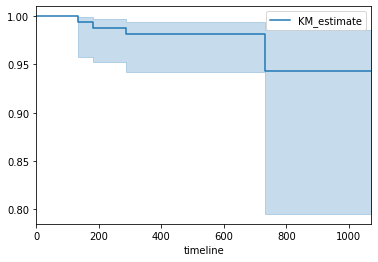

In [45]:
time = focus_group['Path Diag to Last Contact(Day)']
status = focus_group['Vital Status']

kmf = KaplanMeierFitter()
kmf.fit(time, event_observed = status)
kmf.plot()

# Step 4: Format data for Cox's Proportional Hazard test

With the CoxPHFitter from the lifelines package we can see covariate survival plots, as shown below.  The variables we are interested in exploring are Tumor Histologic Grade and Tumor Stage.

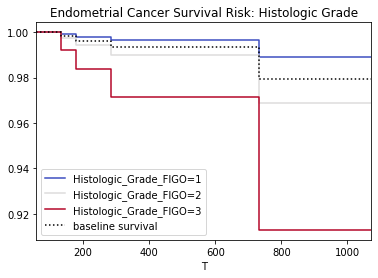

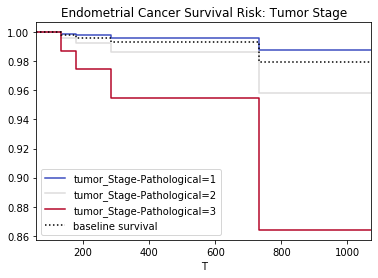

In [39]:
cph = CoxPHFitter()
cph.fit(focus_group, duration_col = "Path Diag to Last Contact(Day)", event_col = "Vital Status")
cph.plot_covariate_groups('Histologic_Grade_FIGO', [1,2,3], cmap='coolwarm', 
                          title= "Endometrial Cancer Survival Risk: Histologic Grade")
cph.plot_covariate_groups('tumor_Stage-Pathological', [1,2,3], cmap='coolwarm', 
                          title= "Endometrial Cancer Survival Risk: Tumor Stage")

# Reword this
These plots appear to have very similar functions across the variables, however, Histologic_Grade_FIGO=3 tends to have less negative outcomes than tumor_Stage-Pathological=3. And, as shown below, with our Survival Regression analysis, Tumor Stage has a lower p-value than Histologic Grade, which is not surprising, since patients with Stage 3 tumors have a greater deviation from the baseline survival function.

In [40]:
cph.print_summary(model="untransformed variables", decimals=3)

<lifelines.CoxPHFitter: fitted with 167 total observations, 163 right-censored observations>
      duration col = 'Path Diag to Last Contact(Day)'
         event col = 'Vital Status'
number of observations = 167.0
number of events observed = 4.0
partial log-likelihood = -13.441
  time fit was run = 2020-02-13 17:28:27 UTC
             model = untransformed variables


---
                          coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
Name                                                                                                                      
Histologic_Grade_FIGO    1.063     2.894     0.663          -0.237           2.362               0.789              10.613
tumor_Stage-Pathological 1.238     3.449     0.518           0.223           2.254               1.249               9.522

                             z     p  -log2(p)
Name                                          
Histologic_Grade_FIGO    1.603 0.109  

We then can perform a Cox Proportional Hazard test, using the *lifelines* package, to determine how much more or less risk a patient would have for the event of interest to occur based on the variables that we are looking at. It also produces a p-value to determine if these variables explain a statistically significant amount of the negative outcomes in our data (moreso than would be expected by random chance).

In [41]:
results = proportional_hazard_test(cph, focus_group, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
                          test_statistic     p  -log2(p)
Histologic_Grade_FIGO              0.006 0.941     0.088
tumor_Stage-Pathological           0.307 0.579     0.787


The hazard ratios for Histologic Grade and Tumor Stage are located in the column labeled "-log2(p)" above. If a ratio is greater than 1, the hazard is greater than would be expected, suggesting that the feature associated with it has a higher likelihood of the negative event occurring than would normally be expected.  Likewise, if the ratio is less than 1, the opposite is true.  A ratio of 1 would be considered normal.

Below, we show confidence intervals for each of the two hazard ratios.  Since both bars include the log(HR) of 1.0 and both of their p-values were greater than 0.05, there is insufficient evidence to suggest that a specific Histologic Grade or Tumor Stage is connected with negative clinical outcomes of death or the development of a new tumor *in our cohort of Endometrial cancer tumors*.

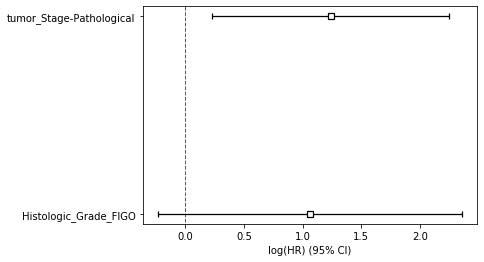

In [42]:
cph.plot()

 It is important to note that there are relatively few patients who had negative outcomes (11 out of 172), which is good, but with such a small sample size, it is difficult to conclude with certainty that these features are not more connected with negative outcomes.  Perhaps a sample of patients with more negative outcomes might have different results.  

It is also important to recognize that the confidence intervals for these ratios are very large, especially since hazard ratios are on a log-scale.

In [43]:
cph.confidence_intervals_

,95% lower-bound,95% upper-bound
Name,,
Histologic_Grade_FIGO,-0.236550,2.362044
tumor_Stage-Pathological,0.222519,2.253567


This is just one example of how you might use Survival Analysis to learn more about different types of cancer, and how clinical and/or genetic attributes contribute to likelihood of survival. There are many other clinical and genetic attributes, as well as several other cancer types, that can be explored using a similar process to that above. In particular, lung cancer and ovarian cancer have a larger number of negative outcomes per cohort, and would be good to look into further. 